In [141]:
from osgeo import gdal
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [142]:
tif_class = r'E:\Desktop\Summary\种植结构提取-水稻\whole_datas\MLSC\MLSC0517_2021-08-22_4074_S2DL.tif'
dataset = gdal.Open(tif_class)
bandclass = dataset.GetRasterBand(1)
dataclass = bandclass.ReadAsArray()
dataclass.astype('int16')  # 设置分类后的数据类型
width = dataset.RasterXSize
height = dataset.RasterYSize
projection = dataset.GetProjection()
geotransform = dataset.GetGeoTransform()
print('完成！！！')

完成！！！


In [143]:
classic = dataclass.reshape(-1)

In [144]:
dfndvi = pd.DataFrame()
ProFiles = os.listdir(r'E:\Desktop\Summary\种植结构提取-水稻\whole_datas\NDVI')
for item in tqdm(ProFiles):
    if item.lower().endswith('.tif'):
        src = (r'E:\Desktop\Summary\种植结构提取-水稻\whole_datas\NDVI\\{}'.format(item))
        dataset = gdal.Open(src)
        ndvi_data = dataset.GetRasterBand(1).ReadAsArray()
        ndvi_data = np.nan_to_num(ndvi_data, nan=999)
        dfndvi[item[9:14]] = (ndvi_data.reshape(-1))
dfndvit = dfndvi.T
dfndvit['x'] = range(6)

100%|██████████| 6/6 [00:08<00:00,  1.34s/it]


In [145]:
dfndgi = pd.DataFrame()
ProFiles = os.listdir(r'E:\Desktop\Summary\种植结构提取-水稻\whole_datas\NDGI')
for item in tqdm(ProFiles):
    if item[-4:] == '.tif':
        src = (r'E:\Desktop\Summary\种植结构提取-水稻\whole_datas\NDGI\\{}'.format(item))
        dataset = gdal.Open(src)
        ndgi_data = dataset.GetRasterBand(1).ReadAsArray()
        ndgi_data = np.nan_to_num(ndgi_data, nan=999)
        dfndgi[item[9:14]] = (ndgi_data.reshape(-1))
dfndgit = dfndgi.T
dfndgit['x'] = range(6)

100%|██████████| 6/6 [00:08<00:00,  1.48s/it]


In [146]:
dfrvi = pd.DataFrame()
ProFiles = os.listdir(r'E:\Desktop\Summary\种植结构提取-水稻\whole_datas\RVI')
for item in tqdm(ProFiles):
    if item[-4:] == '.tif':
        src = (r'E:\Desktop\Summary\种植结构提取-水稻\whole_datas\RVI\\{}'.format(item))
        dataset = gdal.Open(src)
        rvi_data = dataset.GetRasterBand(1).ReadAsArray()
        rvi_data = np.nan_to_num(rvi_data, nan=999)
        dfrvi[item[8:13]] = (rvi_data.reshape(-1))
dfrvit = dfrvi.T
dfrvit['x'] = range(6)

100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


In [147]:
#过滤筛选
x_data = dfndvit['x'].values

In [ ]:
ndvi = dfndvit.T.head(-1).rename(columns={'07-03': 0, '08-02': 1, '08-22': 2, '09-16': 3, '10-06': 4, '10-21': 5})
ndvi

In [151]:
ndvi.iloc[2371353]

0    0.177626
1    0.700582
2    0.842713
3    0.672470
4    0.343528
5    0.318399
Name: 2371353, dtype: float64

In [152]:
NDVI_data = dfndvit.T.head(-1).to_numpy()
#
# for item in NDVI_data:
#      print(np.gradient(item, x_data))
NDVI_data.shape

(30827488, 6)

In [153]:
# ndvi1 = dfndvit.T.head(-1)

In [154]:
mask1 = np.where(((ndvi[3] + ndvi[5]) > 2 * ndvi[4]), 3, 0)
mask1  #玉米
mask2 = np.where(((ndvi[3] + ndvi[5]) < 2 * ndvi[4]), 2, 0)
mask2  #水稻
mask_union = mask1 + mask2

In [155]:
slope_ndvi = []
for item in tqdm(NDVI_data):
    tmp1 = np.gradient(item, x_data)
    slope_ndvi.append(tmp1)
s_ndvi = pd.DataFrame(slope_ndvi)
mask22 = np.where(s_ndvi[5] > -0.12, 1, 0)

100%|██████████| 30827488/30827488 [11:50<00:00, 43401.38it/s]


In [ ]:
s_ndvi

In [25]:
mask22=np.where(s_ndvi[5] > -0.12, 1, 0)
mask22=mask22[:-1]

In [26]:
mask22

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
# from concurrent.futures import ThreadPoolExecutor
#
# slope_ndvi1 = []
#
#
# def get_return(i):
#     tmp1 = np.gradient(i, x_data)
#     slope_ndvi.append(tmp1)
#
#
# with ThreadPoolExecutor(5) as t:
#     for i in tqdm(NDVI_data):
#         t.submit(get_return, i)

In [ ]:
# slope_ndvi1

In [ ]:
# slope_ndvi

In [15]:
mask33 = np.where(2 * s_ndvi[4] < s_ndvi[5]  + s_ndvi[3], 1, 0)  #区分一类 花生
mask33.sum()

23648986

In [28]:
mask33=mask33[:-1]

In [132]:
mask44 = np.where(s_ndvi[2] >0.1 , 1, 0)# 区分一类 旱稻
mask44.sum()

8496412

In [133]:
mask44=mask44[:-1]

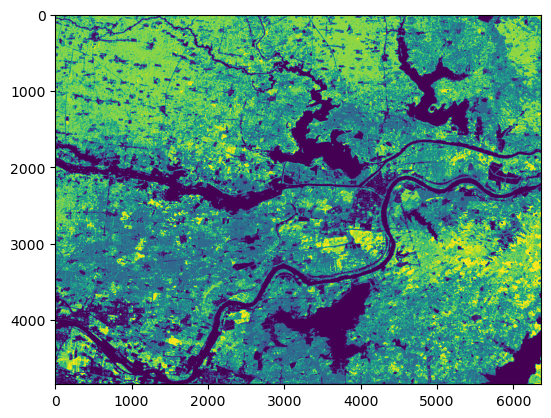

In [134]:
mask_corn = np.where(((classic == 0) & (mask_union == 3)), 3, 0)
mask_rice = np.where(((classic == 0) & (mask_union == 2)), 2, 0)
mask11 = mask_corn + mask_rice
mask00 = np.where(((mask11 == 3) & (mask22 == 1)), 4, mask11)
mask55 = np.where(((mask00 == 4) & (mask33 == 1)), 5, mask00)
mask = np.where(((mask55 == 5) & (mask44 == 1)), 6, mask55)
band = mask.reshape((height, width))
plt.imshow(band)
# plt.savefig(r'E:\Desktop\Summary\种植结构提取-水稻\whole_datas\result05191546.png', dpi=600)

In [135]:
pd.Series(mask55).value_counts()

5    10802093
2     7713311
0     7678981
3     2956842
4     1676261
dtype: int64

In [136]:
pd.Series(mask).value_counts()

5    8034048
2    7713311
0    7678981
3    2956842
6    2768045
4    1676261
dtype: int64

In [139]:
#导出结果
result_path = r'E:\Desktop\Summary\种植结构提取-水稻\whole_datas\result05191729.tif'
target_ds = gdal.GetDriverByName('GTiff').Create(result_path, xsize=width, ysize=height, bands=1,
                                                 eType=gdal.GDT_Int16)
target_ds.SetGeoTransform(dataset.GetGeoTransform())
target_ds.SetProjection(dataset.GetProjection())
del dataset
target_ds.GetRasterBand(1).SetNoDataValue(9999)
target_ds.GetRasterBand(1).WriteArray(band)
target_ds.FlushCache()